In [24]:
import pandas as pd
import yahooquery as yq
from yahooquery import Ticker
import matplotlib.pyplot as plt

In [38]:
def convertir_fecha_a_trimestre(fecha):
    """Convierte una fecha datetime a formato 'YYYY-Qq'."""
    return f"{fecha.year}-Q{(fecha.month - 1) // 3 + 1}"

In [65]:
# Declarar nombre del ticker a trabajar
# simbolo = "MSFT"
# # Descargar datos históricos
# ticker = Ticker(simbolo)
ticker.key_stats[simbolo]

{'maxAge': 1,
 'priceHint': 2,
 'enterpriseValue': 2919902216192,
 'forwardPE': 25.842152,
 'profitMargins': 0.35428002,
 'floatShares': 7423649000,
 'sharesOutstanding': 7433979904,
 'sharesShort': 66334396,
 'sharesShortPriorMonth': 62492832,
 'sharesShortPreviousMonthDate': '2025-01-31 01:00:00',
 'dateShortInterest': '2025-02-28 01:00:00',
 'sharesPercentSharesOut': 0.0089,
 'heldPercentInsiders': 0.00063,
 'heldPercentInstitutions': 0.74397004,
 'shortRatio': 2.68,
 'shortPercentOfFloat': 0.0089,
 'beta': 0.914,
 'impliedSharesOutstanding': 7433979904,
 'category': None,
 'bookValue': 40.712,
 'priceToBook': 9.544114,
 'fundFamily': None,
 'legalType': None,
 'lastFiscalYearEnd': '2024-06-30 02:00:00',
 'nextFiscalYearEnd': '2025-06-30 02:00:00',
 'mostRecentQuarter': '2024-12-31 01:00:00',
 'earningsQuarterlyGrowth': 0.102,
 'netIncomeToCommon': 92749996032,
 'trailingEps': 12.4,
 'forwardEps': 14.95,
 'lastSplitFactor': '2:1',
 'lastSplitDate': '2003-02-18 01:00:00',
 'enterpris

In [73]:
def guardar_estados_financieros(simbolo):
    # Crear un archivo Excel con múltiples hojas
    with pd.ExcelWriter(f"{simbolo}_datos_financieros.xlsx") as writer:
        # Balance
        ticker = Ticker(simbolo)
        balance = ticker.balance_sheet().T
        balance.columns = pd.to_datetime(balance.iloc[0], format='%d/%m/%Y %H:%M:%S')
        # Renombrar los nombres de las columnas con formato "30/06/2021  0:00:00" as "2021-Q2"
        if pd.api.types.is_datetime64_any_dtype(balance.columns):
            balance.columns = balance.columns.to_period("Q").strftime("%Y-Q%q")
        else:
            balance.columns = pd.to_datetime(balance.columns, errors='coerce').to_period("Q").strftime("%Y-Q%q")
        balance.to_excel(writer, sheet_name="Balance")

        # Estado de resultados
        nulos = ticker.income_statement().T.isna().mean()
        # Filtrar columnas que tienen 60% o más de valores nulos
        # columnas_a_eliminar = nulos[nulos >= 0.7].index.tolist()
        # df_limpio = ticker.income_statement().T.drop(columns=columnas_a_eliminar)
        ingresos = ticker.income_statement().T
        ingresos.columns = pd.to_datetime(ingresos.iloc[0], format='%d/%m/%Y %H:%M:%S')
        # Renombrar los nombres de las columnas con formato "30/06/2021  0:00:00" as "2021-Q2"
        ingresos.columns = pd.to_datetime(ingresos.columns).to_period("Q").strftime("%Y-Q%q")
        ingresos.to_excel(writer, sheet_name="Estado_Resultados")

        # Flujo de efectivo
        flujo = ticker.cash_flow().T
        flujo.columns = pd.to_datetime(flujo.iloc[0], format='%d/%m/%Y %H:%M:%S')
        # Renombrar los nombres de las columnas con formato "30/06/2021  0:00:00" as "2021-Q2"
        flujo.columns = pd.to_datetime(flujo.columns).to_period("Q").strftime("%Y-Q%q")
        flujo.to_excel(writer, sheet_name="Flujo_Efectivo")

        historial = ticker.history(period="max")
        historial.to_excel(writer, sheet_name="Historial")

        # Información adicional
        info = ticker.asset_profile
        pd.DataFrame(info).to_excel(writer, sheet_name="Información")

    print(f"Datos financieros de {simbolo} guardados exitosamente")

In [75]:
guardar_estados_financieros("YPFD")

IndexError: At least one sheet must be visible

In [13]:
print(stock.info)

429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TSLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TSLA&crumb=Edge%3A+Too+Many+Requests


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# Visualizar cambio del balance de la empresa a lo largo del tiempo
balance = stock.balancesheet
balance = balance.dropna(axis=1, how="all")
balance = balance.dropna(axis=0, how="all")
balance = balance.T # Transponer para visualización
balance

In [12]:
def obtener_y_graficar_balances(ticker_symbol="TSLA", valores=None):
    """
    Obtiene datos de balance de yfinance y genera gráficos de tarta comparativos.

    Args:
        ticker_symbol: El símbolo del ticker (ej. "TSLA").
        valores: Lista de valores a graficar.
    """

    if valores is None:
        valores = [
            "Treasury Shares Number",
            "Ordinary Shares Number",
            "Share Issued",
            "Total Debt",
            "Tangible Book Value",
            "Invested Capital",
            "Working Capital",
            "Net Tangible Assets",
            "Capital Lease Obligations",
            "Common Stock Equity"
        ]

    stock = Ticker(ticker_symbol)

    try:
        balance_sheet = stock.balance_sheet
    except Exception as e:
        print(f"Error al obtener el balance: {e}")
        return

    if balance_sheet.empty:
        print("No se encontraron datos de balance.")
        return

    # Obtener los dos últimos años disponibles
    years = balance_sheet.columns[:2]
    if len(years) < 2:
        print("No hay suficientes datos para comparar dos años.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Dos subplots uno al lado del otro
    fig.suptitle(f"Comparación de Balances de {ticker_symbol} ({years[0].year} vs {years[1].year})", fontsize=16)


    for i, year in enumerate(years):
        data = balance_sheet[year].loc[valores].dropna() # Seleccionar valores y quitar NaN
        if data.empty: # Comprobar si hay datos para graficar
            axes[i].set_title(f"Sin datos disponibles para {year.year}")
            continue

        axes[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
        axes[i].set_title(f"Balance {year.year}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para evitar superposición de títulos
    plt.show()

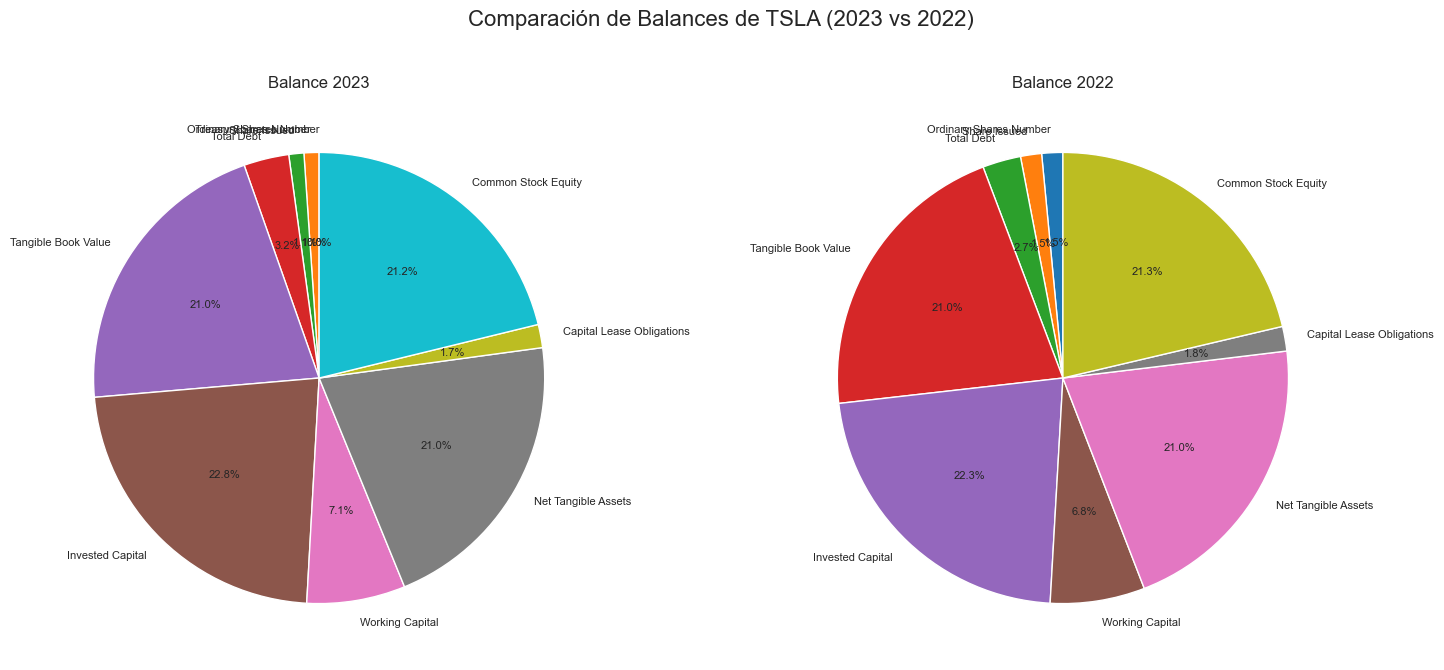

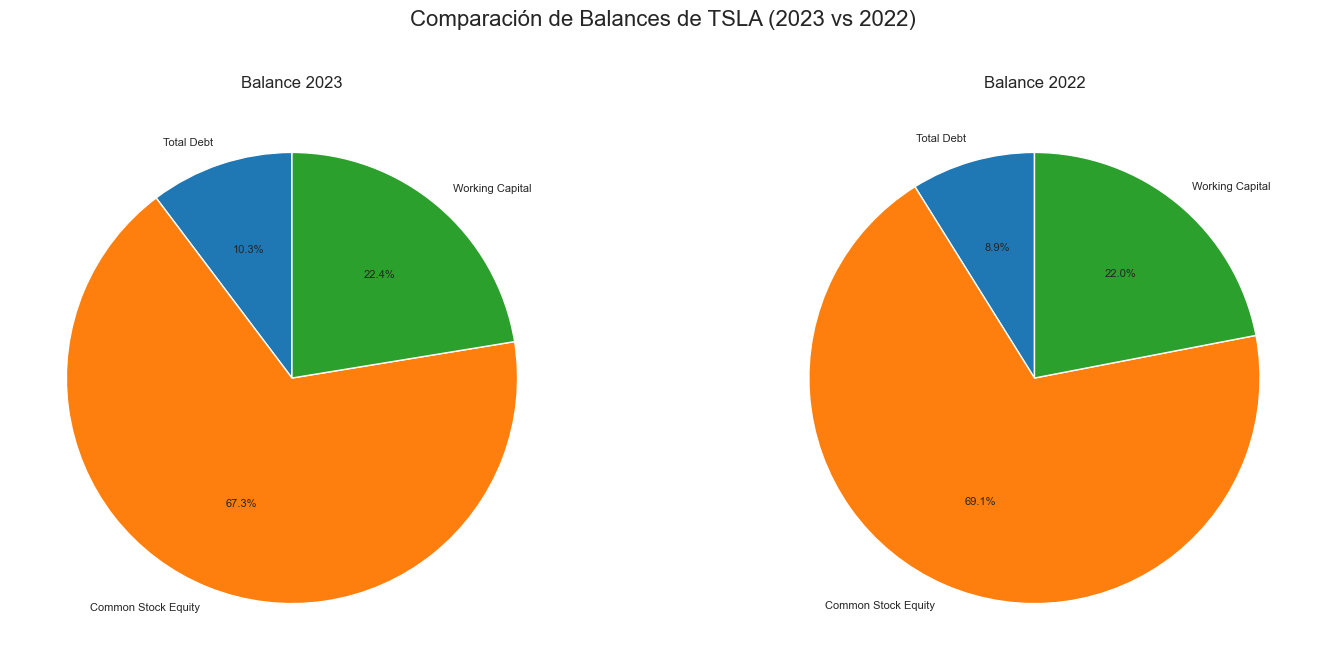

In [13]:
obtener_y_graficar_balances()

# Ejemplo con valores específicos:
valores_especificos = ["Total Debt", "Common Stock Equity", "Working Capital"]
obtener_y_graficar_balances(valores=valores_especificos)
